<a href="https://colab.research.google.com/github/ArthurFDLR/pet-image-segmentation/blob/main/pet-image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# Limit GPU memory allocation for Conv2DTranspose execution
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

import tensorflow_datasets as tfds
try:
    from tensorflow_examples.models.pix2pix import pix2pix
except:
    !pip install -q git+https://github.com/tensorflow/examples.git
    from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
mpl.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

1 Physical GPUs, 1 Logical GPUs


In [2]:
def get_models_history(histories):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    colors_graph = [
    "#927ced",
    "#73bd4d",
    "#e462c0",
    "#eb5e52"]
    handles = []
    for (model_name, history), color in zip(histories.items(), colors_graph):
        axs[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], c=color, ls='-.', alpha=.7, marker='o', ms=3)
        axs[0].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=model_name, c=color, marker='o', ms=3)
        axs[1].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], c=color, ls='-.', alpha=.7, marker='o', ms=3)
        axs[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=model_name, c=color, marker='o', ms=3)
        handles.append(mpatches.Patch(color=color, label=model_name))
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('accuracy')
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
    handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))
    fig.subplots_adjust(right=0.85)
    fig.legend(handles=handles,
        loc="center right",
        borderaxespad=1)
    return fig

# Semantic segmentation

In [3]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'UNet Prediction', 'Conv-Deconv Prediction']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

## Import data

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

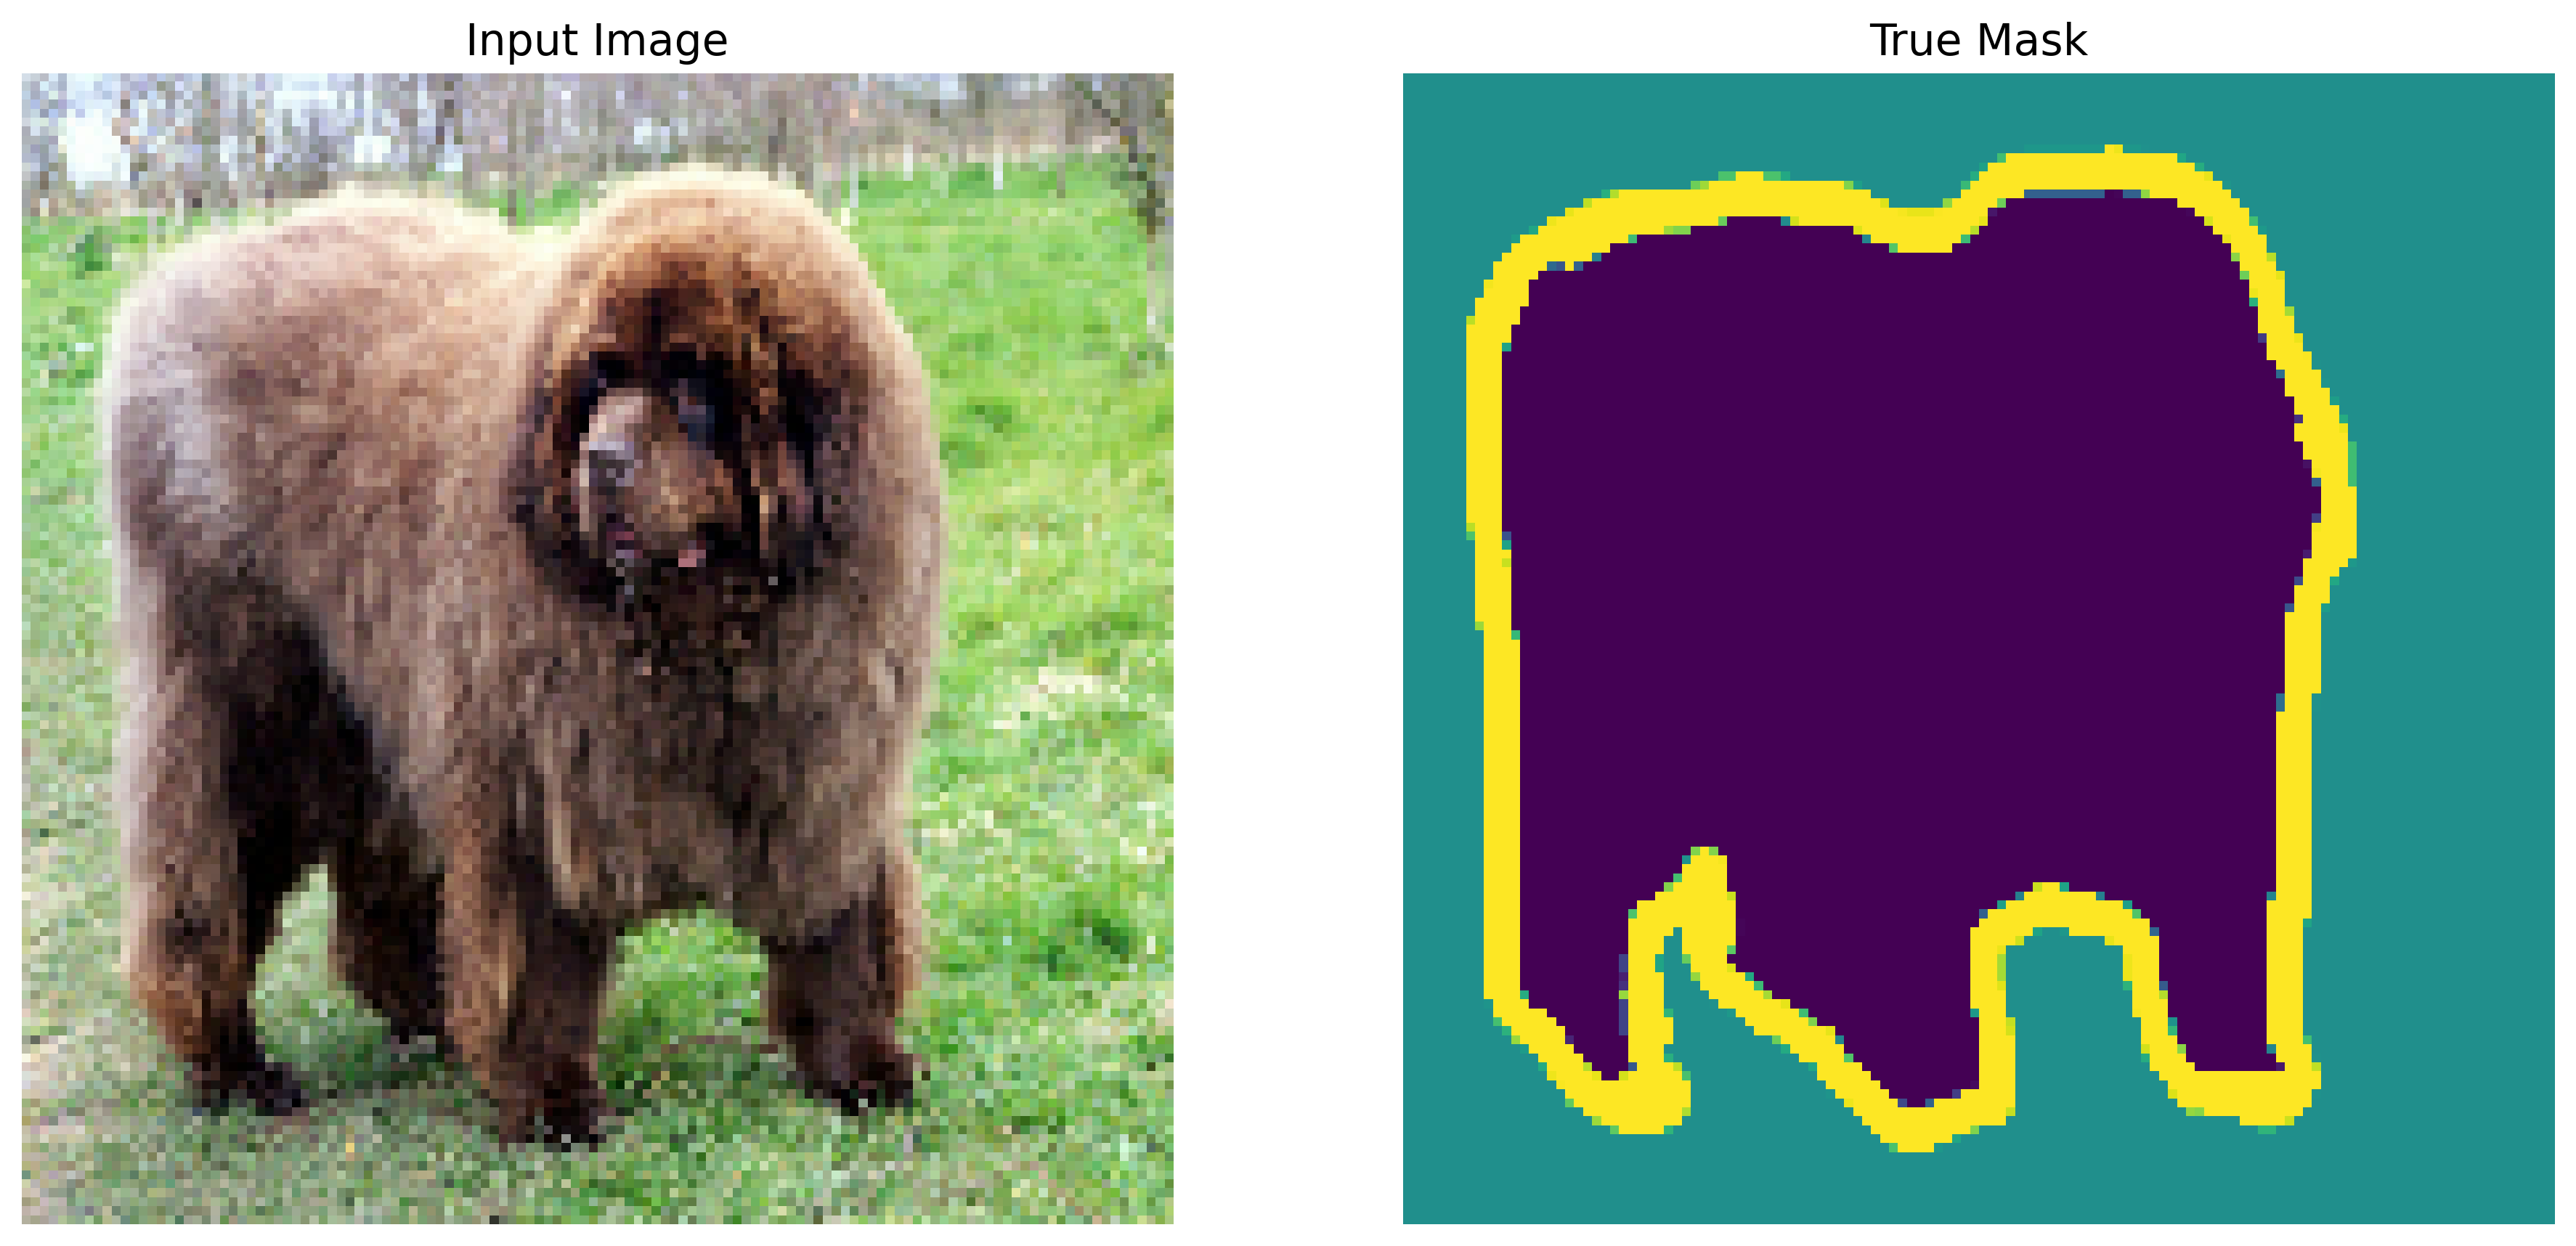

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

for image, mask in train.take(7):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Build model

### Basic model

In [6]:
basic_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(128,128,3)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=2, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation="relu", padding="same"),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, padding="same")
    ]
)
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 3)       1731      
Total params: 62,243
Trainable params: 62,243
Non-trainable params: 0
____________________________________________________

### Custom U-Net

In [7]:
encoder_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
encoder_model_outputs = [encoder_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
encoder_stack = tf.keras.Model(inputs=encoder_model.input, outputs=encoder_model_outputs)

encoder_stack.trainable = False

decoder_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


inputs = tf.keras.layers.Input(shape=[128, 128, 3])
# Downsampling through the model
skips = encoder_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(decoder_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(
  3, 3, strides=2,
  padding='same')  #64x64 -> 128x128

x = last(x)

UNet_model = tf.keras.Model(inputs=inputs, outputs=x)
UNet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 64, 64, 96), 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 512)    1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential_1[0][0]               
                                                                 functional_1[0][3]    

## Train

In [8]:
EPOCHS = 25
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

training_histories = {}

In [9]:
name = 'Conv-Deconv'
weights_path = ".\weights\{}.h5".format(name)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, verbose=0, save_best_only=True)

basic_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
training_histories[name] = basic_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          shuffle=True,
                          callbacks=[checkpointer],
                          verbose=0)

In [10]:
name = 'U-Net'
weights_path = ".\weights\{}.h5".format(name)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, verbose=0, save_best_only=True)

UNet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
training_histories[name] = UNet_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          shuffle=True,
                          callbacks=[checkpointer],
                          verbose=0)

<ipython-input-11-9261e2dbbb81>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  get_models_history(training_histories).show()


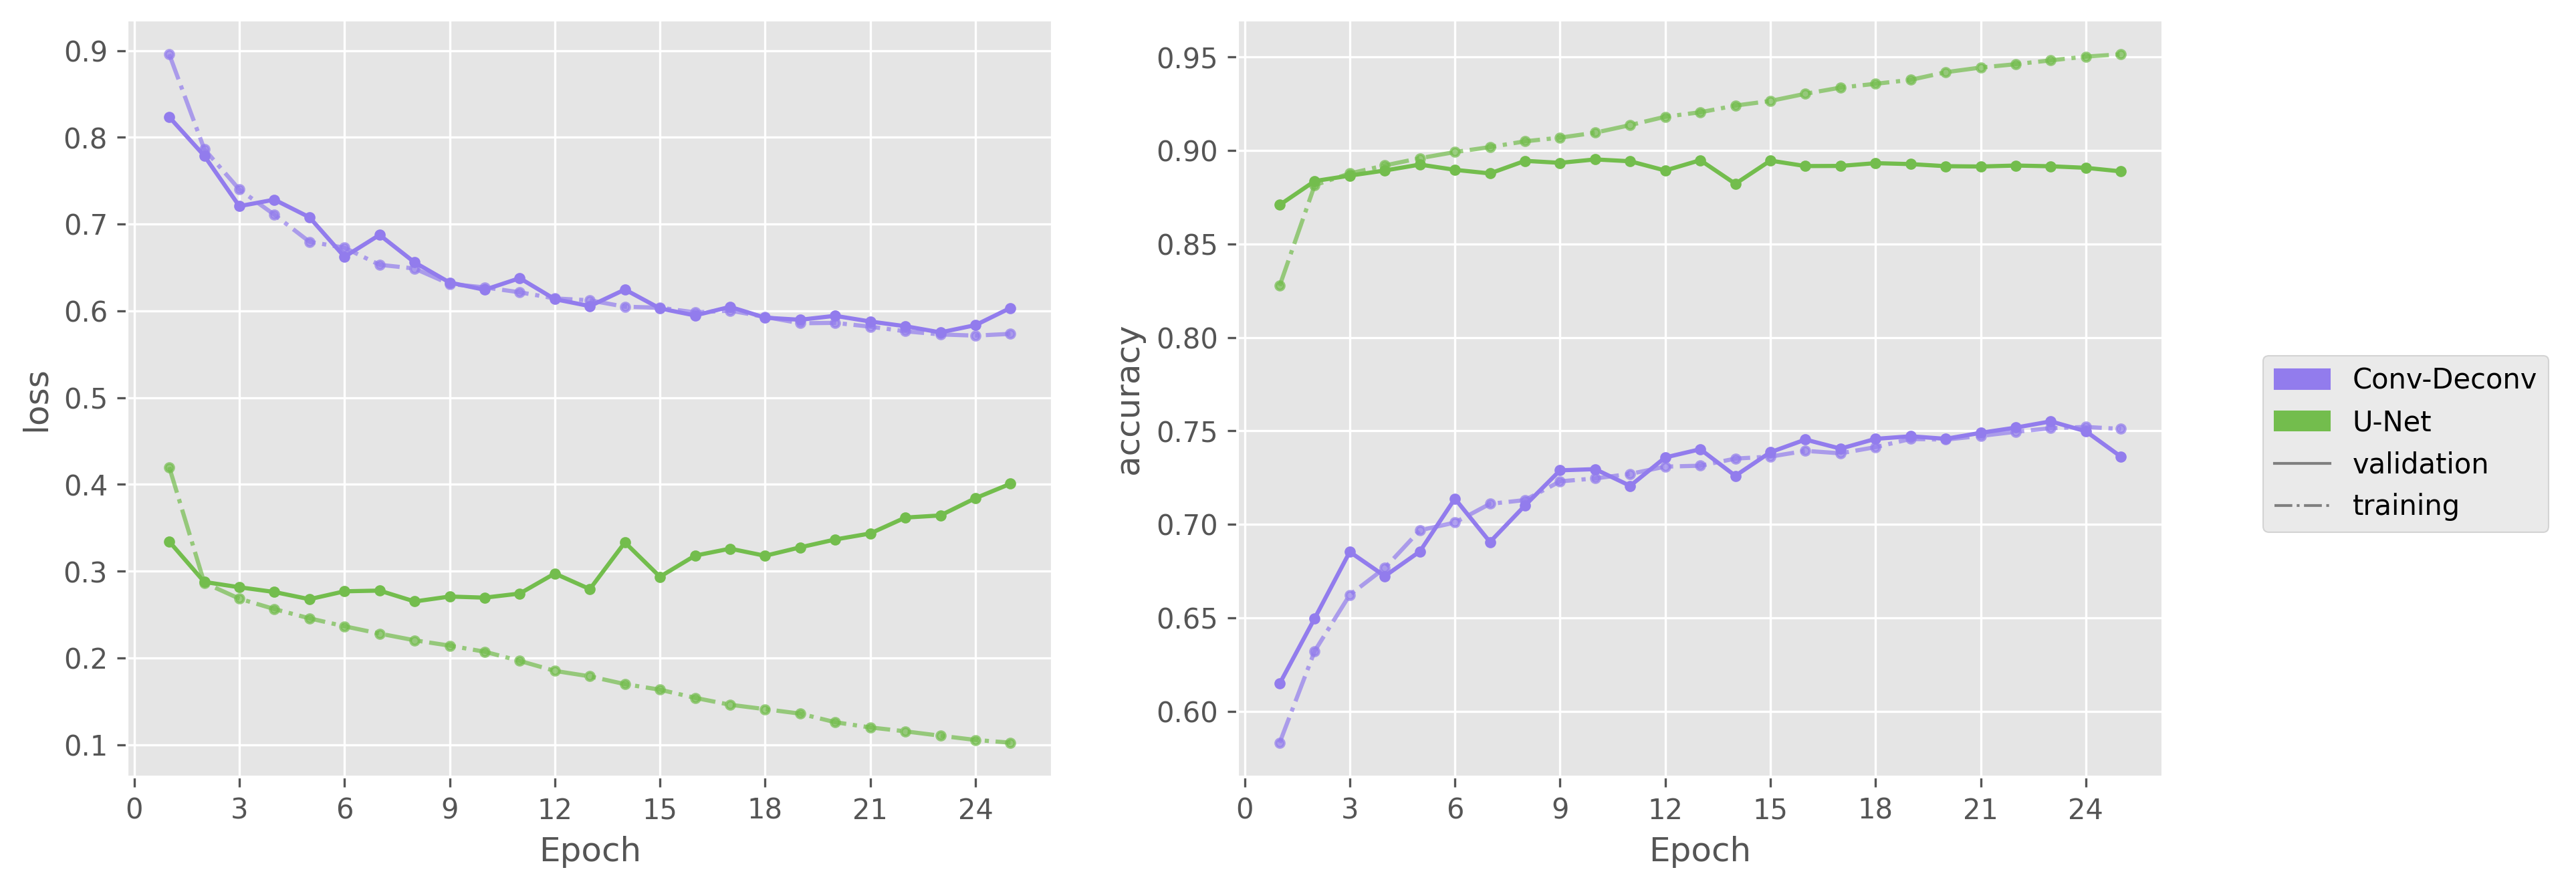

In [11]:
get_models_history(training_histories).show()

## Evaluate

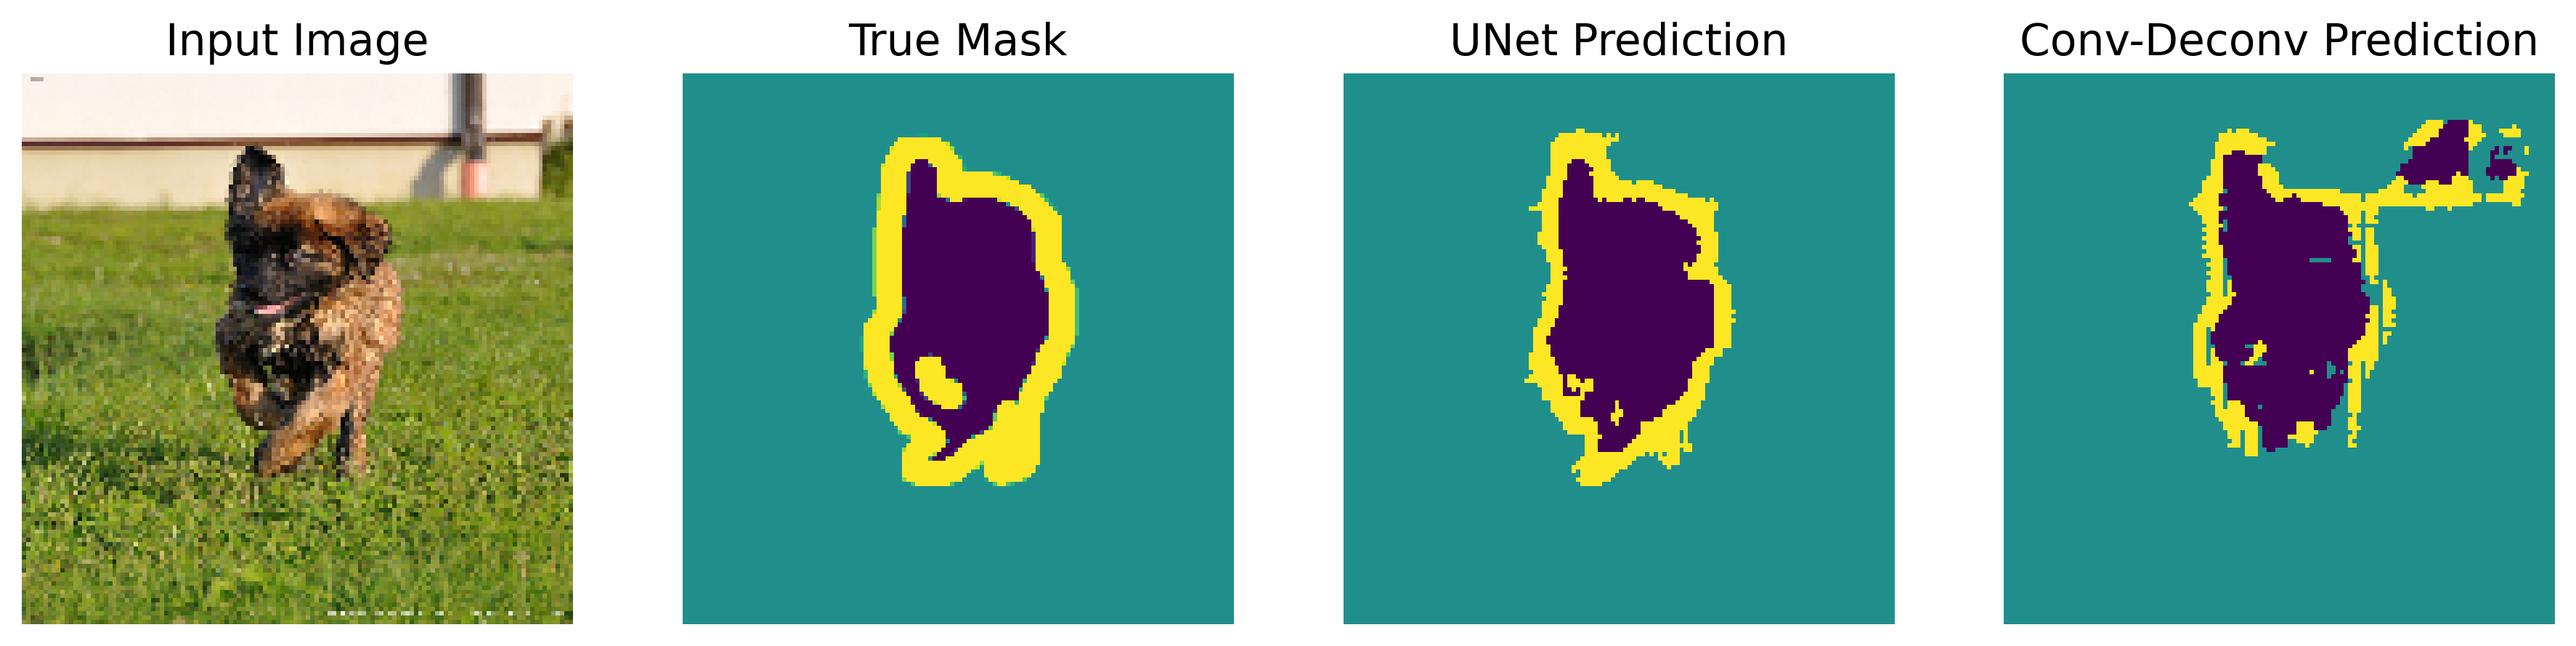

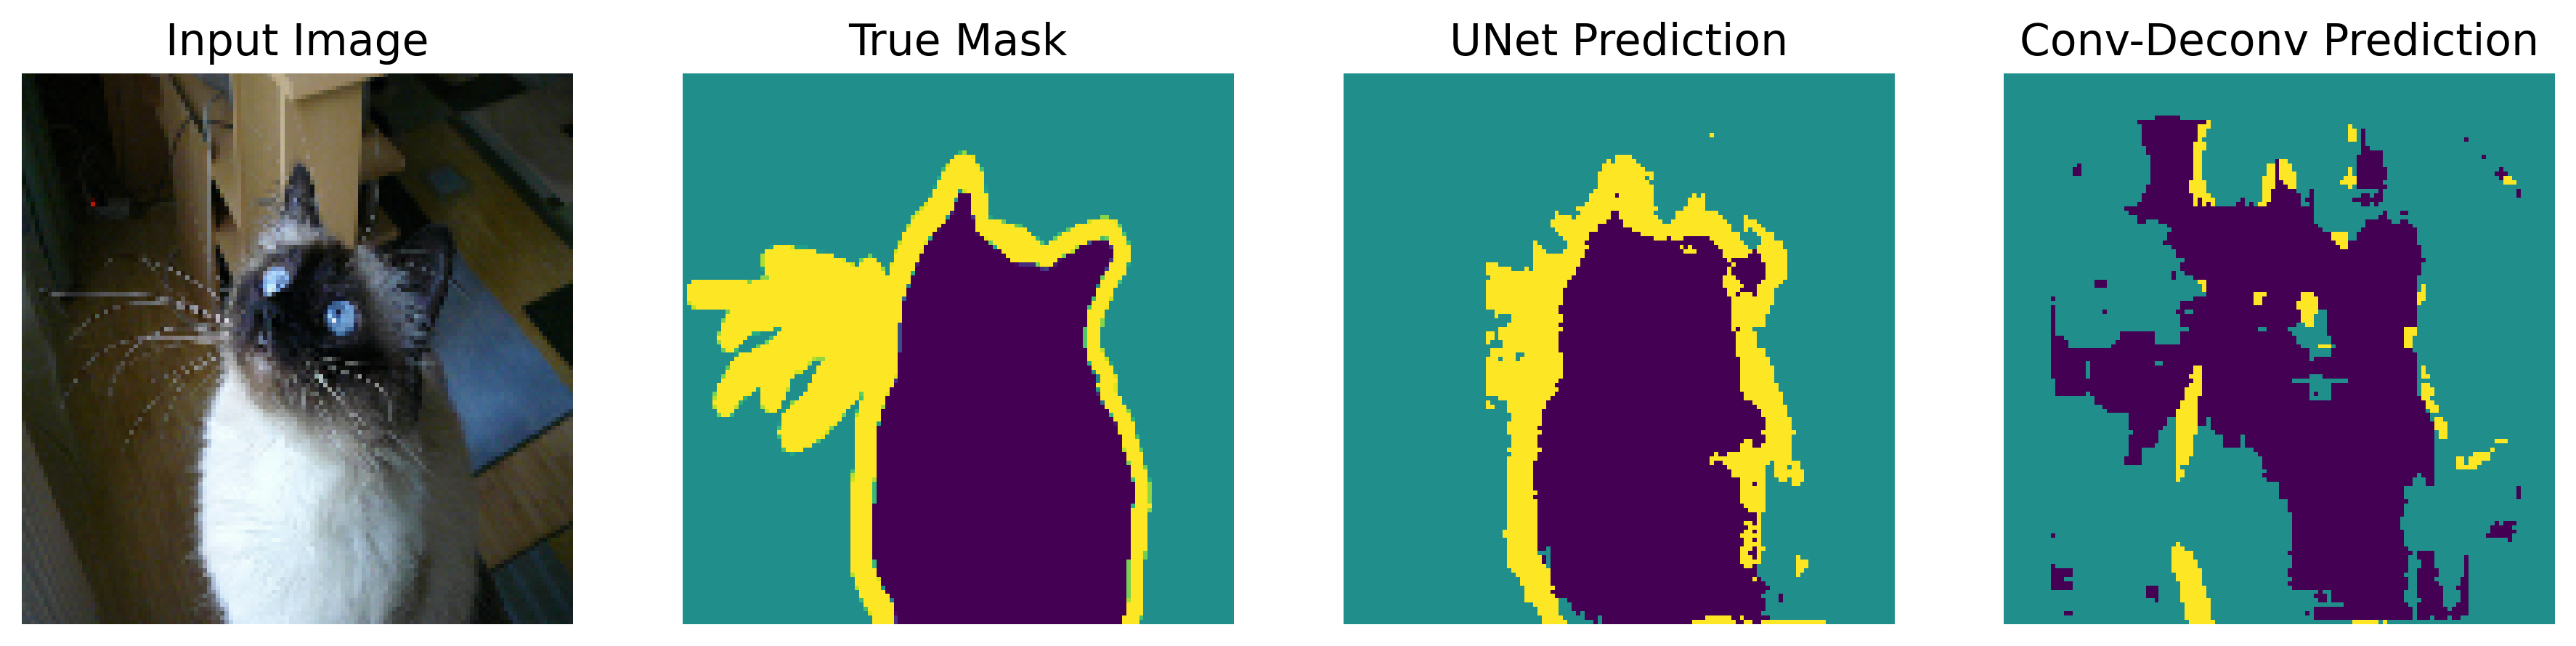

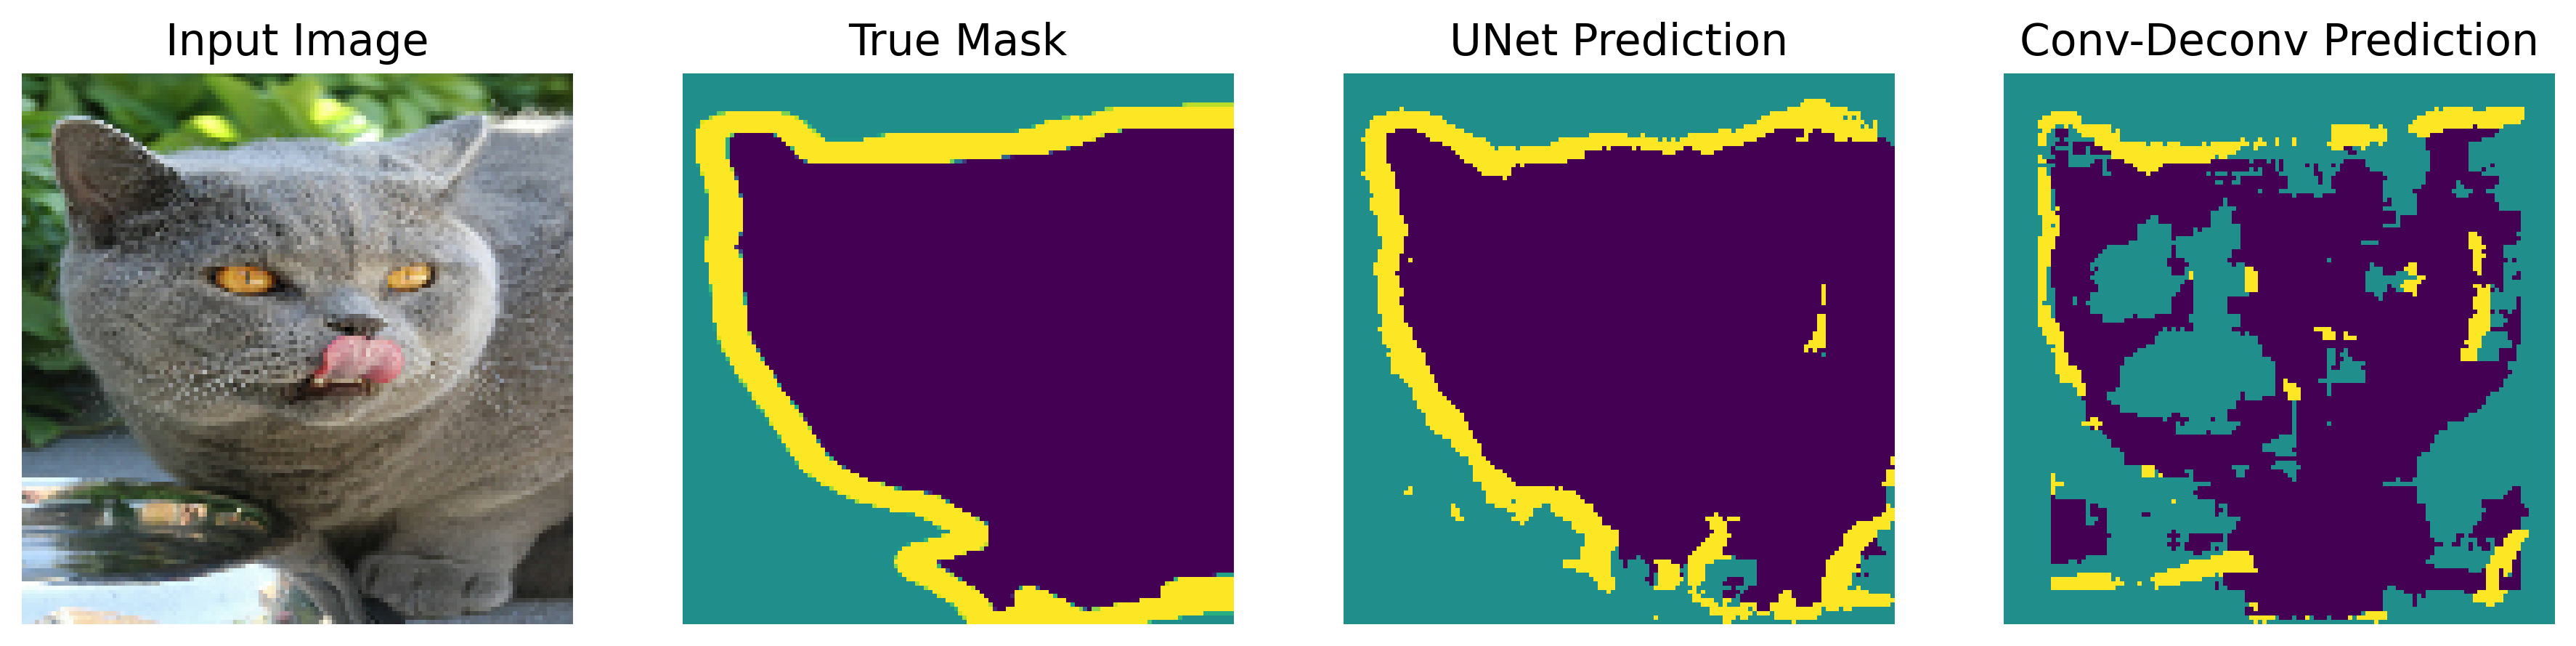

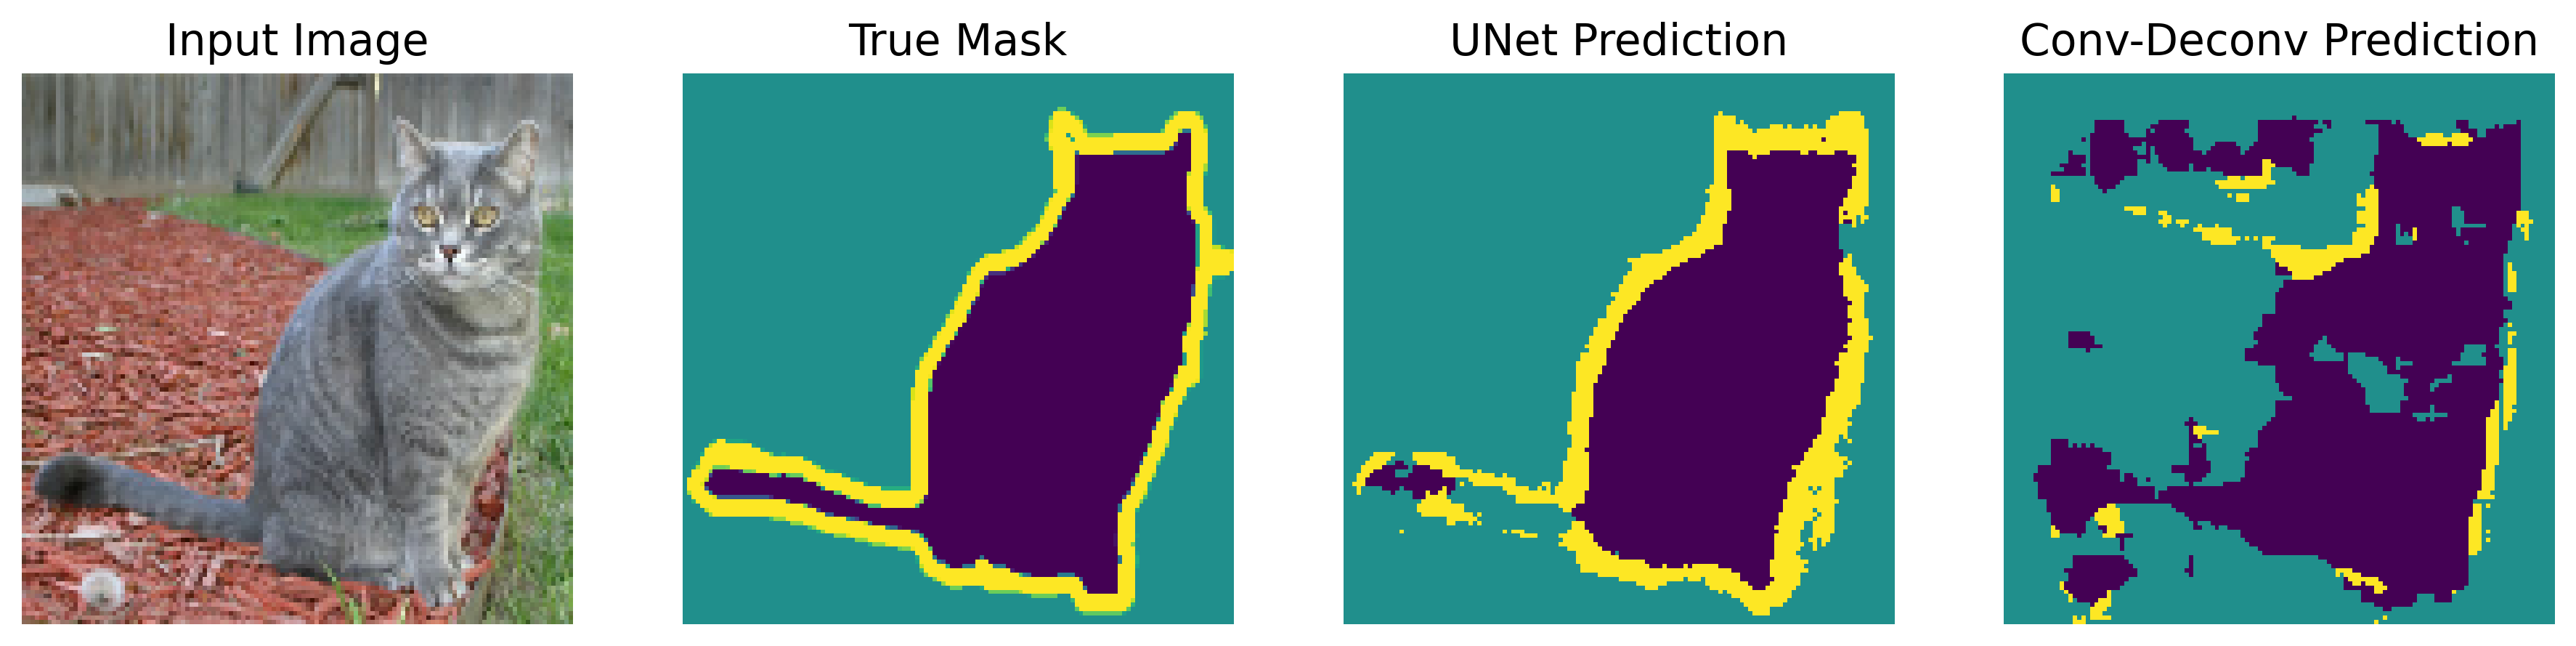

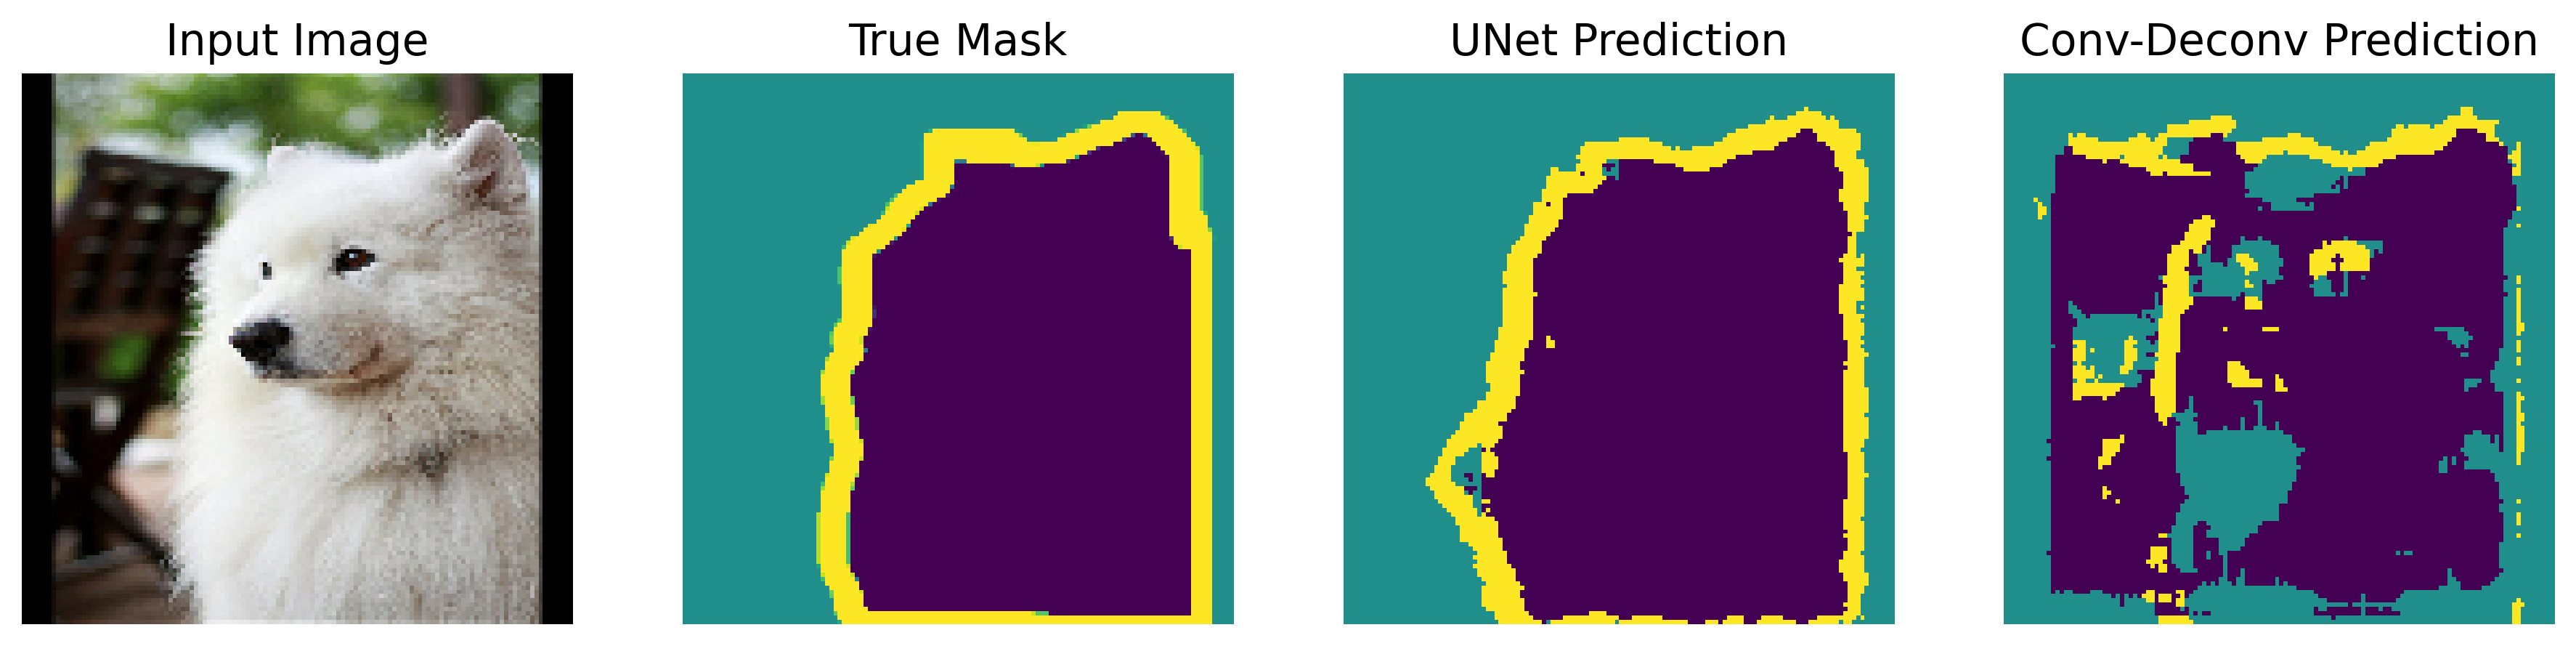

In [12]:
conv_deconv_model = tf.keras.models.load_model("./weights/Conv-Deconv.h5")
UNet_model = tf.keras.models.load_model("./weights/U-Net.h5")

for image, mask in test_dataset.take(5):
    UNet_mask = UNet_model.predict(image)
    conv_deconv_mask = conv_deconv_model.predict(image)
    display([image[0], mask[0], create_mask(UNet_mask), create_mask(conv_deconv_mask)])